# spam vs. non-spam emails

## I. Problem Statement  <a name="objective"></a>

To determine whether email is spam or non-spam email based on the email characteristics that are given.

**Objectives**
1. Build the classification model with best predictive accuracy
2. Build the best cost-sensitive classification model

## II. Data Information

**[Data Source](http://archive.ics.uci.edu/ml/datasets/Spambase)**


Specifically, the file “spambase.data” contains the actual data, and files “spambase.names” and “spambase.DOCUMENTATION” contain the description of the data. This dataset has 4601 records, each record representing a different email message. Each record is described with 58 attributes (indicated in the aforementioned .names file): attributes 1-57 represent various content-based characteristics already extracted from each email message (related to the frequency of certain words or certain punctuation symbols in a message as well as to the usage of capital letters in a message), and the last attribute represents the class label for each message (spam or non-spam).

In [704]:
# Load packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import math
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import neighbors, datasets
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [93]:
# Load data
spam_base = pd.read_csv('spambase.data', sep=",", header = None, 
                             names = ['wf_make', 'wf_address', 'wf_all', 'wf_3d', 'wf_our', 'wf_over', 'wf_remove',
                                      'wf_internet','wf_order', 'wf_mail', 'wf_receive', 'wf_will', 'wf_people',
                                      'wf_report', 'wf_addresses', 'wf_free', 'wf_business','wf_email','wf_you',
                                      'wf_credit', 'wf_your', 'wf_font','wf_000', 'wf_money', 'wf_hp', 'wf_hpl', 
                                      'wf_george', 'wf_650','wf_lab','wf_labs','wf_telnet', 'wf_857', 'wf_data',
                                      'wf_415', 'wf_85', 'wf_technology', 'wf_1999', 'wf_parts', 'wf_pm', 'wf_direct',
                                      'wf_cs', 'wf_meeting','wf_original','wf_project','wf_re', 'wf_edu', 'wf_table',
                                      'wf_conference', 'cf_semicolon','cf_parenthesis','cf_bracket', 'cf_exc','cf_dollar','cf_pound',
                                      'cr_avg', 'cr_longest','cr_tota','spam_class'])

### III. Data Exploration

In [94]:
# check the number of columns and rows for the dataset
spam_base.shape

(4601, 58)

In [95]:
# All continous numeric data
spam_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wf_make         4601 non-null   float64
 1   wf_address      4601 non-null   float64
 2   wf_all          4601 non-null   float64
 3   wf_3d           4601 non-null   float64
 4   wf_our          4601 non-null   float64
 5   wf_over         4601 non-null   float64
 6   wf_remove       4601 non-null   float64
 7   wf_internet     4601 non-null   float64
 8   wf_order        4601 non-null   float64
 9   wf_mail         4601 non-null   float64
 10  wf_receive      4601 non-null   float64
 11  wf_will         4601 non-null   float64
 12  wf_people       4601 non-null   float64
 13  wf_report       4601 non-null   float64
 14  wf_addresses    4601 non-null   float64
 15  wf_free         4601 non-null   float64
 16  wf_business     4601 non-null   float64
 17  wf_email        4601 non-null   f

In [96]:
spam_base.groupby(['spam_class'])['spam_class'].count()

spam_class
0    2788
1    1813
Name: spam_class, dtype: int64

**Data Exploration:**

Observing the dataset, there are 57 attributes and all are continuous data, and the target variable is spam_class where 0 indicates not spam, and 1 indicates spam. The ratio between class 1 : class 0 is 0.65, which is a little imbalance. Thus, class_Weight = balanced is used to deal with this situation.

The objective of the problem is to determine whether an email is spam or not. Thus, this is a classification problem. 

In addition, the cost ratio is 10:1 and in this scenario, it is more harmful to misclassify an spam email as normal email as spam emails may contain virus or scam and can hurt receivers or organizations badly, and it is less harmful to misclassify an normal email as spam as people can still check the spam box to look for the email if they know an email is not spam. 

Thus, the cost for false negative is 10 and cost for false positive is 1. (Positive means it's spam (1), and negative means it's not spam (0)). 

**Data Prepartion**

X (attributes) and y(spam class) have been break out from the dataset.

Then, data are slipted data into training and testing with test size of 0.2.



**Model Selection:**

I first used Accuracy as the measurement metrics to select the best model, and then used the average misclassification cost for find the best cost-sensitive model. Models that were tried are logistics regression, Decision Tree, KNN, SVM, neural network (MLPClassifier) and ensemble model (Regression Tree). 

For each model, multiple hyper-parameters were set. In order to find the best model. I used nested cross validation and KFold with n_splits = 5. 

It is also worth to mention that all attributes are continuous data, thus data needs to be normalized for models: logistics regression, KNN, and SVM. Therefore, pipeline has been built for these data to normalize data while avoid data leakage.

By comparing the mean score of each model, the model with best mean score is chosen for model evaluation.


**Hyper-parameter tuning and model evaluation:**

To optimize hyper-parameter and evaluate the chosen model, I used the Grid Search cross validation and evaluate its performance.

More details of the model performance are listed at the end of each models

### IIII. Data Preparation

In [97]:
# define dataset
Xs = spam_base.iloc[:, :56]
ys = spam_base['spam_class']

In [98]:
# Split data into training and testing
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs,ys, test_size=0.2, random_state = 32)

In [99]:
# Model comparison with nested CV
inner_cv = KFold(n_splits=5, shuffle=True, random_state=6)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=7)
scoring = 'accuracy'

### V. Model

### Objective 1. Best predictive accuracy model

#### 5.1.1 Model Selection

#### Logistic Regression

In [204]:
# set up the logistic regression model and the different hyper parameters
lr_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty':['l1','l2', 'none']}
lr = linear_model.LogisticRegression(class_weight = 'balanced') 

In [205]:
# Non_nested parameter search and scoring
lr_clf= GridSearchCV(estimator=lr, param_grid=lr_grid, scoring=scoring, cv=inner_cv)

In [206]:
# define the pipeline for normalization and avoid data leakage
steps = list()
steps.append(('scaler', StandardScaler()))
steps.append(('model', lr_clf))
pipeline = Pipeline(steps=steps)

In [207]:
# Nested CV with parameter optimization 
lr_score = cross_val_score(pipeline, Xs_train, y=ys_train, cv=outer_cv)
lr_score.mean()

0.9271739130434783

Running Logistic Regression, we get the mean accuaracy of 0.927

#### Decision Tree

In [201]:
# set up the decision tree model and the different hyper parameters
dt = DecisionTreeClassifier(class_weight = 'balanced')

dt_grid = {
        'max_depth':list(range(1,16)),
        'min_samples_leaf': [5, 10, 15],
        'criterion': ["gini", "entropy"]
}

In [202]:
# Non_nested parameter search and scoring
dt_clf = GridSearchCV(estimator=dt, param_grid=dt_grid, scoring = scoring, cv=inner_cv)

In [203]:
# Nested CV with parameter optimization
dt_score = cross_val_score(dt_clf, X=Xs_train, y=ys_train, cv=outer_cv)
dt_score
dt_score.mean()

0.9184782608695652

From the decesion tree model, we get a mean accuracy of 0.918

#### KNN

In [107]:
# set up the knn model and the different hyper parameters
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
knn_grid = dict(n_neighbors = k_range, weights = weight_options)

knn = KNeighborsClassifier()

In [108]:
# Non_nested parameter search and scoring
knn_clf =  GridSearchCV(estimator=knn, param_grid=knn_grid, scoring = scoring, cv=inner_cv)

In [109]:
# define the pipeline for normalization and avoid data leakage
steps = list()
steps.append(('scaler', StandardScaler()))
steps.append(('model', knn_clf))
pipeline = Pipeline(steps=steps)

In [110]:
# Nested CV with parameter optimization 
knn_score = cross_val_score(pipeline, X=Xs_train, y=ys_train, cv=outer_cv)
knn_score.mean()

0.9168478260869565

Running Logistic Regression, we get the mean accuracy of 0.917

#### SVM

In [111]:
# set up the svm model and the different hyper parameters
svm_grid = [{'kernel': ['rbf'], 'gamma': [1e2, 1e1, 1, 1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

svm = SVC(class_weight = 'balanced')

In [112]:
# using randomizedSearchCV for hyper parameter tuning 
svm_clf = RandomizedSearchCV(estimator=svm, param_distributions=svm_grid, n_iter = 6, 
                             random_state=12, scoring =  scoring, cv=inner_cv)

In [113]:
# define the pipeline for normalization and avoid data leakage
steps = list()
steps.append(('scaler', StandardScaler()))
steps.append(('model', svm_clf))
pipeline = Pipeline(steps=steps)

In [114]:
# Nested CV with parameter optimization 
svm_score = cross_val_score(pipeline, Xs_train, y=ys_train, cv=outer_cv)
svm_score.mean() 

0.9320652173913043

Running SVM, we get the mean accuracy of 0.932

#### Nueral Network

In [115]:
# set up the svm model and the different hyper parameters
nn = MLPClassifier()
nnc_grid = {
    'hidden_layer_sizes': [(30,30,30), (30,60,30), (100,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05]}

In [162]:
# using RandomizedSearchCV for hyper parameter tuning 
nn_clf = RandomizedSearchCV(nn, param_distributions=nnc_grid, random_state=10,
                              scoring = scoring, cv=inner_cv)

In [163]:
# Nested CV with parameter optimization
nn_score = cross_val_score(nn_clf, X=Xs_train, y=ys_train, cv=outer_cv)
nn_score
nn_score.mean()

0.944836956521739

Running the neural network classifier model, we get accuracy score of 0.945

#### Ensemble Model - Random Forest

In [212]:
# set up the regression tree model
rfc = RandomForestClassifier(class_weight = 'balanced')

# set up the param_grid
rfc_grid = {'criterion':['gini', 'entropy', 'log_loss'],
            'max_depth':list(range(1,20)),
            'min_samples_leaf': [5, 10, 15]}

In [213]:
# using RandomizedSearchCV for hyper parameter tuning 
rf_clf = RandomizedSearchCV(rfc, param_distributions=rfc_grid, n_iter = 5, scoring = scoring, random_state = 24,
                             n_jobs = -1, cv=inner_cv)

In [214]:
# Nested CV with parameter optimization
rf_clf_score = cross_val_score(rf_clf, X=Xs_train, y=ys_train, cv=outer_cv)
rf_clf_score
rf_clf_score.mean()

0.94375

Running the ensemble model random forest, we get accuracy score of 0.943.

Comparing performance of logistics regression, decision tree, knn, svm, nerural network, and ensemble model (ranfom forest), neural network classifier has the best performance with highest accuracy of 0.945. Thus, I will now retrain the model and optimize the hyperparameter.

#### 5.1.2 Optimize Hyperparameter and Model Evaluation

In [691]:
# Split data into training and testing 
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs,ys, test_size=0.2, random_state = 12)

# set up the nn classifier model and the different hyper parameters
nn = MLPClassifier()

nnc_grid = {'hidden_layer_sizes': [(30,30,30), (30,60,30), (100,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05]}

nn_clf = RandomizedSearchCV(nn, param_distributions=nnc_grid, random_state=10,
                              scoring = scoring, cv=6)
nn_clf.fit(Xs_train, ys_train)


RandomizedSearchCV(cv=6, estimator=MLPClassifier(),
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'alpha': [0.0001, 0.05],
                                        'hidden_layer_sizes': [(30, 30, 30),
                                                               (30, 60, 30),
                                                               (100,)]},
                   random_state=10, scoring='accuracy')

In [692]:
print ("Accuracy: \n",nn_clf.best_score_)
print (nn_clf.best_params_)
print (nn_clf.best_estimator_)

Accuracy: 
 0.947558154569914
{'hidden_layer_sizes': (100,), 'alpha': 0.05, 'activation': 'tanh'}
MLPClassifier(activation='tanh', alpha=0.05)


In [693]:
# Obtained the best estimator: MLPClassifier{'hidden_layer_sizes': (100,), 'alpha': 0.05, 'activation': 'tanh'}

# Now we can evaluate the model performance with test data
clf_nn = nn_clf.best_estimator_

nn_pred_test = clf_nn.predict(Xs_test)

print("Classification Report: \n",classification_report(ys_test, nn_pred_test))
print("Prediction Accuracy: ", accuracy_score(ys_test, nn_pred_test))

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       578
           1       0.94      0.92      0.93       343

    accuracy                           0.95       921
   macro avg       0.95      0.95      0.95       921
weighted avg       0.95      0.95      0.95       921

Prediction Accuracy:  0.9511400651465798


In [694]:
print("Confusion Matrix: \n", confusion_matrix(ys_test, nn_pred_test))

Confusion Matrix: 
 [[559  19]
 [ 26 317]]


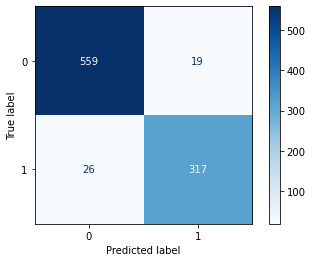

In [695]:
# confusion matrix
from sklearn.metrics import plot_confusion_matrix

X, y = make_classification()

plot_confusion_matrix(clf_nn, Xs_test, ys_test, cmap=plt.cm.Blues)
plt.show()

0.945663139205262


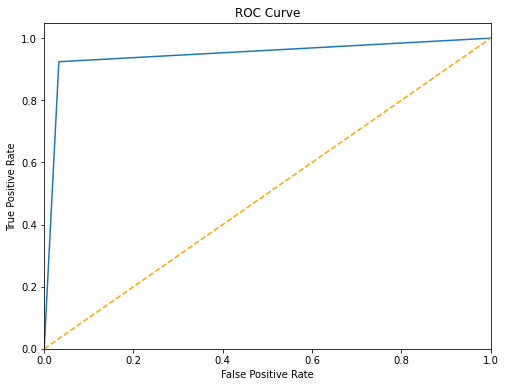

In [696]:
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ys_test, nn_pred_test)
    roc_auc[i] = auc(fpr[i], tpr[i])

print(roc_auc_score(ys_test, nn_pred_test))
plt.figure(figsize=(8, 6))
plt.plot(fpr[1], tpr[1])
plt.plot([0,1],[0,1], '--', color = 'orange', label ='baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

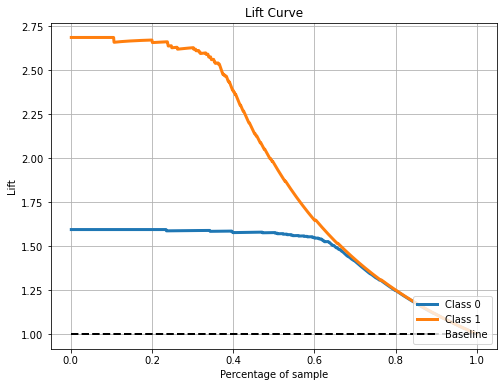

In [697]:
# Lift curve

pred1 = clf_nn.predict_proba(Xs_test)
import scikitplot as skplt

skplt.metrics.plot_lift_curve(
    ys_test, pred1, figsize=(8, 6),
)
plt.show()

The best estimator of the model is: MLPClassifier{'hidden_layer_sizes': (100,), 'alpha': 0.05, 'activation': 'tanh'}

Evaulating the performance of the neural network model with its best estimator, the model performs very well with accuracy of 0.951. We also obtained a 92% recall and 94% precision for class 'spam' and 97% precision and 96% recall for class 'non-spam'. Looking at the confusion Matrix, fn is 26, and fp is 19, which meaning there are more spam email being misclassified as normal email, than normal email being misclassified as spam email, and the misclassifying cost is 279.

From the ROC curve of the final model rsult, we also see that the curve is very close to the top left corner and the area below the curve is 0.946, which is close to one and well performed.

As for the lift curve, both curves indicated that the model is doing much better than random guess (baseline).

Overall, the model performance is pretty good.

###  Objective 2. Considering Misclassifying cost

#### 5.2.1 Model Selection

In [612]:
# define misclassifying score for gridsearch
from sklearn.metrics import confusion_matrix, make_scorer

def misclassifying_cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = fn*10 + fp*1
    return cost

score = make_scorer(misclassifying_cost, greater_is_better=False)

#### Logistic Regression

In [613]:
# set up the logistic regression model and the different hyper parameters
lr_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty':['l1','l2', 'none']}
lr = linear_model.LogisticRegression(class_weight = 'balanced') 

In [614]:
# Non_nested parameter search and scoring
lr_clf= GridSearchCV(estimator=lr, param_grid=lr_grid, scoring=score, cv=inner_cv)

In [615]:
# define the pipeline for normalization and avoid data leakage
steps = list()
steps.append(('scaler', StandardScaler()))
steps.append(('model', lr_clf))
pipeline = Pipeline(steps=steps)

In [616]:
# Nested CV with parameter optimization 
lr_score = cross_val_score(pipeline, Xs_train, y=ys_train, cv=outer_cv)
lr_score.mean()

-262.6

Running Logistic Regression, we get a mean misclassifying cost of 262.6.

#### Decision Tree

In [617]:
# set up the decision tree model and the different hyper parameters
dt = DecisionTreeClassifier(class_weight = 'balanced')

# define the dt_grid
dt_grid = {
        'max_depth':list(range(1,16)),
        'min_samples_leaf': [5, 10, 15],
        'criterion': ["gini", "entropy"]
}

# Non_nested parameter search and scoring
dt_clf1 = GridSearchCV(estimator=dt, param_grid=dt_grid, scoring = score, cv=inner_cv)

# Nested CV with parameter optimization
dt1_score = cross_val_score(dt_clf1, X=Xs_train, y=ys_train, cv=outer_cv)
dt1_score
dt1_score.mean()

-360.8

From the decesion tree model, we get a mean misclassifying cost of 360.8

#### KNN

In [618]:
# set up the knn model and the different hyper parameters
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
knn_grid = dict(n_neighbors = k_range, weights = weight_options)

knn = KNeighborsClassifier()

# Non_nested parameter search and scoring
knn_clf1 =  GridSearchCV(estimator=knn, param_grid=knn_grid, scoring = score, cv=inner_cv)

# define the pipeline for normalization and avoid data leakage
steps = list()
steps.append(('scaler', StandardScaler()))
steps.append(('model', knn_clf1))
pipeline = Pipeline(steps=steps)

# Nested CV with parameter optimization 
knn1_score = cross_val_score(pipeline, X=Xs_train, y=ys_train, cv=outer_cv)
knn1_score.mean()

-357.8

From the knn model, we get a mean misclassifying cost of 357.8

#### SVM

In [621]:
# set up the logistic regression model and the different hyper parameters
svm_grid = [{'kernel': ['rbf'], 'gamma': [1e2, 1e1, 1, 1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
svm = SVC(class_weight = 'balanced')


# Non_nested parameter search and scoring
svm_clf1 = RandomizedSearchCV(estimator=svm, param_distributions=svm_grid, n_iter = 6, 
                             random_state=12, scoring = score, cv=inner_cv)

# define the pipeline for normalization and avoid data leakage
steps = list()
steps.append(('scaler', StandardScaler()))
steps.append(('model', svm_clf1))
pipeline = Pipeline(steps=steps)

# Nested CV with parameter optimization 
svm_score1 = cross_val_score(pipeline, Xs_train, y=ys_train, cv=outer_cv)
svm_score1.mean()

-288.8

From the SVM model, we get a mean misclassifying cost of 288.8.

#### Neural Network

In [630]:
# set up the svm model and the different hyper parameters
nn = MLPClassifier()
nnc_grid = {
    'hidden_layer_sizes': [(30,30,30), (30,60,30), (100,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05]}

In [637]:
# using RandomizedSearchCV for hyper parameter tuning 
nn_clf = RandomizedSearchCV(nn, param_distributions=nnc_grid, random_state=24,
                              scoring = score, cv=inner_cv)

In [638]:
# Nested CV with parameter optimization
nn_score = cross_val_score(nn_clf, X=Xs_train, y=ys_train, cv=outer_cv)
nn_score
nn_score.mean()

-201.8

From the neural network classifier model, we get a mean misclassifying cost of 201.8

#### Ensemble Model - Random Forest

In [626]:
# set up the regression tree model
rfc = RandomForestClassifier(class_weight = 'balanced')

# set up the param_grid
rfc_grid = {'criterion':['gini', 'entropy', 'log_loss'],
            'max_depth':list(range(1,20)),
            'min_samples_leaf': [5, 10, 15]}

# using RandomizedSearchCV for hyper parameter tuning 
rf_clf1 = RandomizedSearchCV(rfc, param_distributions=rfc_grid, n_iter = 5, scoring = score, random_state = 24,
                             n_jobs = -1, cv=10)

# Nested CV with parameter optimization
rfc1_score = cross_val_score(rf_clf1, X=Xs_train, y=ys_train, cv=outer_cv)
rfc1_score
rfc1_score.mean()

-249.4

For ensemble model Random Forest, we get a mean misclassifying cost of 249.4.

Comparing all models, neural network classifier has the best performance with lowest misclassifying cost of 201.8. Thus, I will now retrain the model and optimize the hyperparameter.

#### 5.2.2 Optimize Hyperparameter and Model Evaluation

In [649]:
# Split data into training and testing 
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs,ys, test_size=0.2, random_state = 1)

# set up the nn classifier model and the different hyper parameters
nn = MLPClassifier()

nnc_grid = {'hidden_layer_sizes': [(30,30,30), (30,60,30), (100,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05]}

nn_clf1 = RandomizedSearchCV(nn, param_distributions=nnc_grid, random_state=24,
                              scoring = score, cv=6)
nn_clf1.fit(Xs_train, ys_train)


RandomizedSearchCV(cv=6, estimator=MLPClassifier(),
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'alpha': [0.0001, 0.05],
                                        'hidden_layer_sizes': [(30, 30, 30),
                                                               (30, 60, 30),
                                                               (100,)]},
                   random_state=24,
                   scoring=make_scorer(misclassifying_cost, greater_is_better=False))

In [657]:
print ("Misclassifying cost: \n",nn_clf1.best_score_)
print (nn_clf1.best_params_)
print (nn_clf1.best_estimator_)

Misclassifying cost: 
 -162.16666666666666
{'hidden_layer_sizes': (100,), 'alpha': 0.05, 'activation': 'tanh'}
MLPClassifier(activation='tanh', alpha=0.05)


In [658]:
# Obtained the best estimator: MLPClassifier{'hidden_layer_sizes': (100,), 'alpha': 0.05, 'activation': 'tanh'}

# Now we can evaluate the model performance with test data
clf_nn1 = nn_clf1.best_estimator_

nn_pred_test1 = clf_nn1.predict(Xs_test)

print("Classification Report: \n",classification_report(ys_test, nn_pred_test1))
print("Prediction Accuracy: ", accuracy_score(ys_test, nn_pred_test1))

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       564
           1       0.93      0.95      0.94       357

    accuracy                           0.95       921
   macro avg       0.95      0.95      0.95       921
weighted avg       0.95      0.95      0.95       921

Prediction Accuracy:  0.9533116178067318


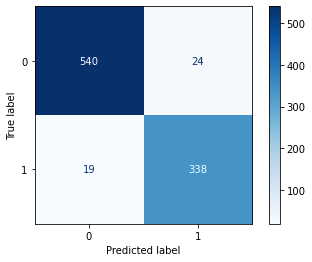

In [659]:
# confusion matrix
from sklearn.metrics import plot_confusion_matrix

X, y = make_classification()

plot_confusion_matrix(clf_nn1, Xs_test, ys_test, cmap=plt.cm.Blues)
plt.show()

In [666]:
misclassifying_cost(ys_test, nn_pred_test1)

214

From the confusion matrix, we observed fp = 24 and fn = 19. Thus, the cost = 214.

0.9521127599976161


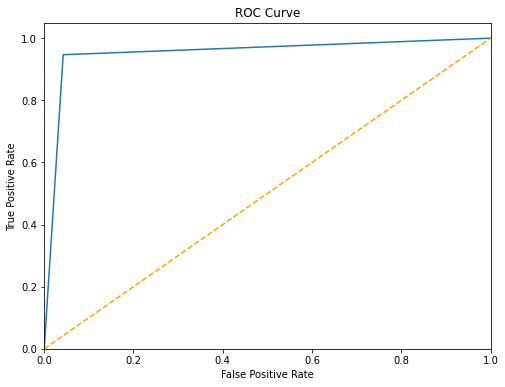

In [661]:
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ys_test, nn_pred_test1)
    roc_auc[i] = auc(fpr[i], tpr[i])

print(roc_auc_score(ys_test, nn_pred_test1))
plt.figure(figsize=(8, 6))
plt.plot(fpr[1], tpr[1])
plt.plot([0,1],[0,1], '--', color = 'orange', label ='baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

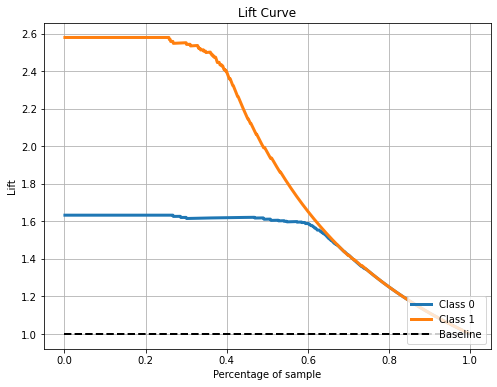

In [662]:
# Lift curve

pred1 = clf_nn1.predict_proba(Xs_test)
import scikitplot as skplt

skplt.metrics.plot_lift_curve(
    ys_test, pred1, figsize=(8, 6),
)
plt.show()

The best estimator of the model is: MLPClassifier{'hidden_layer_sizes': (100,), 'alpha': 0.05, 'activation': 'tanh'}

Evaulating the performance of the neural network model with its best estimator( MLPClassifier{'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'tanh'}), the model performs very well with accuracy of 0.953. We also obtained a 95% recall and 93% precision for class 'spam' and 97% precision and 96% recall for class 'non-spam'. The recall for positive class (spam) is higher than preicison, which meet our goal to catch as many spam email as possible.

In additon, looking at the confusion Matrix, fn is 19, and fp is 24, which is also well performed as misclassiying a spam email as normal email is less than misclassiyfing a non-spam email as spam. And, we also obtained a lower misclassiying cost of 214.

From the ROC curve of the final model rsult, we also see that the curve is very close to the top left corner and the area below the curve is 0.95, which is close to one and well performed.

As for the lift curve, both curves indicated that the model is doing much better than random guess (baseline).

Overall, the model performance is robust.